# Set up notebook

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
!pip install pycaret

In [5]:
import pycaret
from pycaret.regression import *


# Set display results
pd.options.display.float_format = '{:,.4f}'.format
%config InlineBackend.figure_format = 'retina'

# PyCaret version
print(f'PyCaret version: {pycaret.__version__}')

PyCaret version: 3.1.0


# Import Data

The current data used to build the model is car sales prices from CarDekho. This dataset was chosen because it requires encoding techniques for categorical variables, not just numeric ones, showcasing diverse data preprocessing. The sample dataset can be downloaded from the link provided.
(https://www.kaggle.com/datasets/nehalbirla/vehicle-dataset-from-cardekho)

In [7]:
df = pd.read_csv('car data.csv')
df.head(5)

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.3500,5.5900,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.7500,9.5400,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.2500,9.8500,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.8500,4.1500,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.6000,6.8700,42450,Diesel,Dealer,Manual,0


In [9]:
# Create 'age' variable
df['age'] = 2023 - df['Year'] #Using 2023 as latest year
df = df[df['age'] <= 10] #Drop data more than 10 years
df

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner,age
0,ritz,2014,3.3500,5.5900,27000,Petrol,Dealer,Manual,0,9
1,sx4,2013,4.7500,9.5400,43000,Diesel,Dealer,Manual,0,10
2,ciaz,2017,7.2500,9.8500,6900,Petrol,Dealer,Manual,0,6
4,swift,2014,4.6000,6.8700,42450,Diesel,Dealer,Manual,0,9
5,vitara brezza,2018,9.2500,9.8300,2071,Diesel,Dealer,Manual,0,5
...,...,...,...,...,...,...,...,...,...,...
295,city,2015,8.5500,13.0900,60076,Diesel,Dealer,Manual,0,8
296,city,2016,9.5000,11.6000,33988,Diesel,Dealer,Manual,0,7
297,brio,2015,4.0000,5.9000,60000,Petrol,Dealer,Manual,0,8
299,city,2017,11.5000,12.5000,9000,Diesel,Dealer,Manual,0,6


In [12]:
# Create 'RV' as target
df['RV'] = df['Selling_Price'] / df['Present_Price']
df['logRV'] = np.log(df['RV'])
df.head(5)

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner,age,RV,logRV
0,ritz,2014,3.3500,5.5900,27000,Petrol,Dealer,Manual,0,9,0.5993,-0.5120
1,sx4,2013,4.7500,9.5400,43000,Diesel,Dealer,Manual,0,10,0.4979,-0.6973
2,ciaz,2017,7.2500,9.8500,6900,Petrol,Dealer,Manual,0,6,0.7360,-0.3065
4,swift,2014,4.6000,6.8700,42450,Diesel,Dealer,Manual,0,9,0.6696,-0.4011
5,vitara brezza,2018,9.2500,9.8300,2071,Diesel,Dealer,Manual,0,5,0.9410,-0.0608


# Model Training

In [46]:
# Set up model
from pycaret.regression import *
regression = setup(df,
                   target = 'logRV',
                   train_size = 0.8,
                   categorical_features = ['Car_Name', 'Fuel_Type', 'Transmission', 'Owner'],
                   categorical_imputation = 'constant', # For deployment purposes
                   numeric_features = ['Kms_Driven', 'age'],
                   numeric_imputation = 'mean', # For deployment purposes
                   normalize = True,
                   normalize_method = 'minmax',
                   polynomial_features = True,
                   polynomial_degree = 2,
                   ignore_features = ['Year', 'Present_Price', 'Seller_Type','RV'],
                   fold = 5,
                   n_jobs = -1,)

,Description,Value
0,Session id,8973
1,Target,logRV
2,Target type,Regression
3,Original data shape,"(218, 12)"
4,Transformed data shape,"(218, 55)"
5,Transformed train set shape,"(174, 55)"
6,Transformed test set shape,"(44, 55)"
7,Ignore features,4
8,Ordinal features,2
9,Numeric features,2


# Compare Model

The compare_models() function facilitates the fitting of multiple models conveniently and offers additional options:

- include: Accepts a list of model abbreviations present in models(). It designates which models the data will be fitted to. If you want to specify a list of models to exclude from fitting, you can use exclude instead.

- sort: Specifies how the results should be ordered. For instance, for regression models, the R-Square value might be used to gauge accuracy. Therefore, setting it to 'R2' will order the models starting with the highest R-Square value.

- n_select: Determines the number of candidate models from all the fitting results. Setting it to 5 means the top 5 models, ordered by R-Square (as specified above), will be chosen as candidate models.

In [47]:
# Compare models
estimatedModels = compare_models(include = ['ridge',
                                            'gbr',
                                            'rf',
                                            'et',
                                            'ada',
                                            'knn',
                                            'lightgbm',
                                            'dt',
                                            'lr',
                                            'lasso',
                                            'xgboost',
                                            'en',
                                            'svm'],
                                 sort = 'R2',
                                 n_select = 5)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,0.1130,0.0206,0.1424,0.5497,0.1032,0.8130,0.7260
ada,AdaBoost Regressor,0.1156,0.0208,0.1432,0.5468,0.1034,0.8255,0.2160
gbr,Gradient Boosting Regressor,0.1124,0.0212,0.1440,0.5426,0.1043,0.7705,0.2280
lightgbm,Light Gradient Boosting Machine,0.1207,0.0230,0.1500,0.5045,0.1088,0.8220,0.1860
ridge,Ridge Regression,0.1197,0.0237,0.1521,0.5018,0.1094,0.9195,1.0860
svm,Support Vector Regression,0.1214,0.0249,0.1548,0.4926,0.1111,0.8924,0.1320
xgboost,Extreme Gradient Boosting,0.1162,0.0229,0.1504,0.4903,0.1090,0.7219,0.2300
et,Extra Trees Regressor,0.1166,0.0235,0.1515,0.4797,0.1094,0.7581,0.4920
knn,K Neighbors Regressor,0.1265,0.0261,0.1592,0.4540,0.1135,0.8222,0.1380
dt,Decision Tree Regressor,0.1270,0.0273,0.1646,0.3932,0.1204,0.7935,0.1420


Processing:   0%|          | 0/61 [00:00<?, ?it/s]

In [60]:
# print best model
best_model = estimatedModels[0]
best_model

RandomForestRegressor(n_jobs=-1, random_state=8973)

# Evaluate Model

In [62]:
evaluate_model(best_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

## Select model

In [56]:
model = create_model('rf')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.1141,0.0185,0.1361,0.7164,0.1012,0.9969
1,0.1248,0.0299,0.1730,0.5876,0.1185,0.8494
2,0.0925,0.0144,0.1200,0.5839,0.0855,0.3445
3,0.1211,0.0206,0.1435,0.3620,0.1073,0.5523
4,0.1126,0.0194,0.1393,0.4986,0.1036,1.3216
Mean,0.1130,0.0206,0.1424,0.5497,0.1032,0.8130
Std,0.0112,0.0051,0.0173,0.1168,0.0107,0.3410


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

# Tuning Model

You can further tune the model parameters depending on the type of model chosen. Depending on the model, there are specific parameters that can be tuned to enhance the model's performance.

In [57]:
tuned_ridge = tune_model(model)
tuned_ridge

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.1458,0.0289,0.1700,0.5577,0.1244,1.4034
1,0.1364,0.0347,0.1862,0.5223,0.1264,1.0005
2,0.0994,0.0153,0.1239,0.5567,0.0886,0.3982
3,0.1089,0.0181,0.1347,0.4382,0.1008,0.5288
4,0.1151,0.0230,0.1516,0.4061,0.1117,1.4174
Mean,0.1211,0.0240,0.1533,0.4962,0.1104,0.9497
Std,0.0173,0.0070,0.0227,0.0626,0.0143,0.4263


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


RandomForestRegressor(n_jobs=-1, random_state=8973)

Next, we use finalize_model() to obtain the final model for prediction with the data. The result is a model object that can be saved or loaded for future use.

In [51]:
finalModel = finalize_model(tuned_ridge)
finalModel

Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['Kms_Driven', 'age'],
                                    transformer=SimpleImputer())),
                ('categorical_imputer',
                 TransformerWrapper(include=['Car_Name', 'Fuel_Type',
                                             'Transmission', 'Owner'],
                                    transformer=SimpleImputer(fill_value='constant',
                                                              strategy='constant'))),
                ('ordinal_encoding',
                 TransformerWrappe...
                ('rest_encoding',
                 TransformerWrapper(include=['Car_Name'],
                                    transformer=TargetEncoder(cols=['Car_Name'],
                                                              handle_missing='return_nan'))),
                ('polynomial_features',
                 TransformerWrapper(transformer=PolynomialFeatures(include_bias=False))),
                ('normalize', TransformerWrapper(transformer=MinMaxScaler())),
                ('actual_estimator',
                 Ridge(alpha=6.33, fit_intercept=False, random_state=8973))])

# Analyze Model

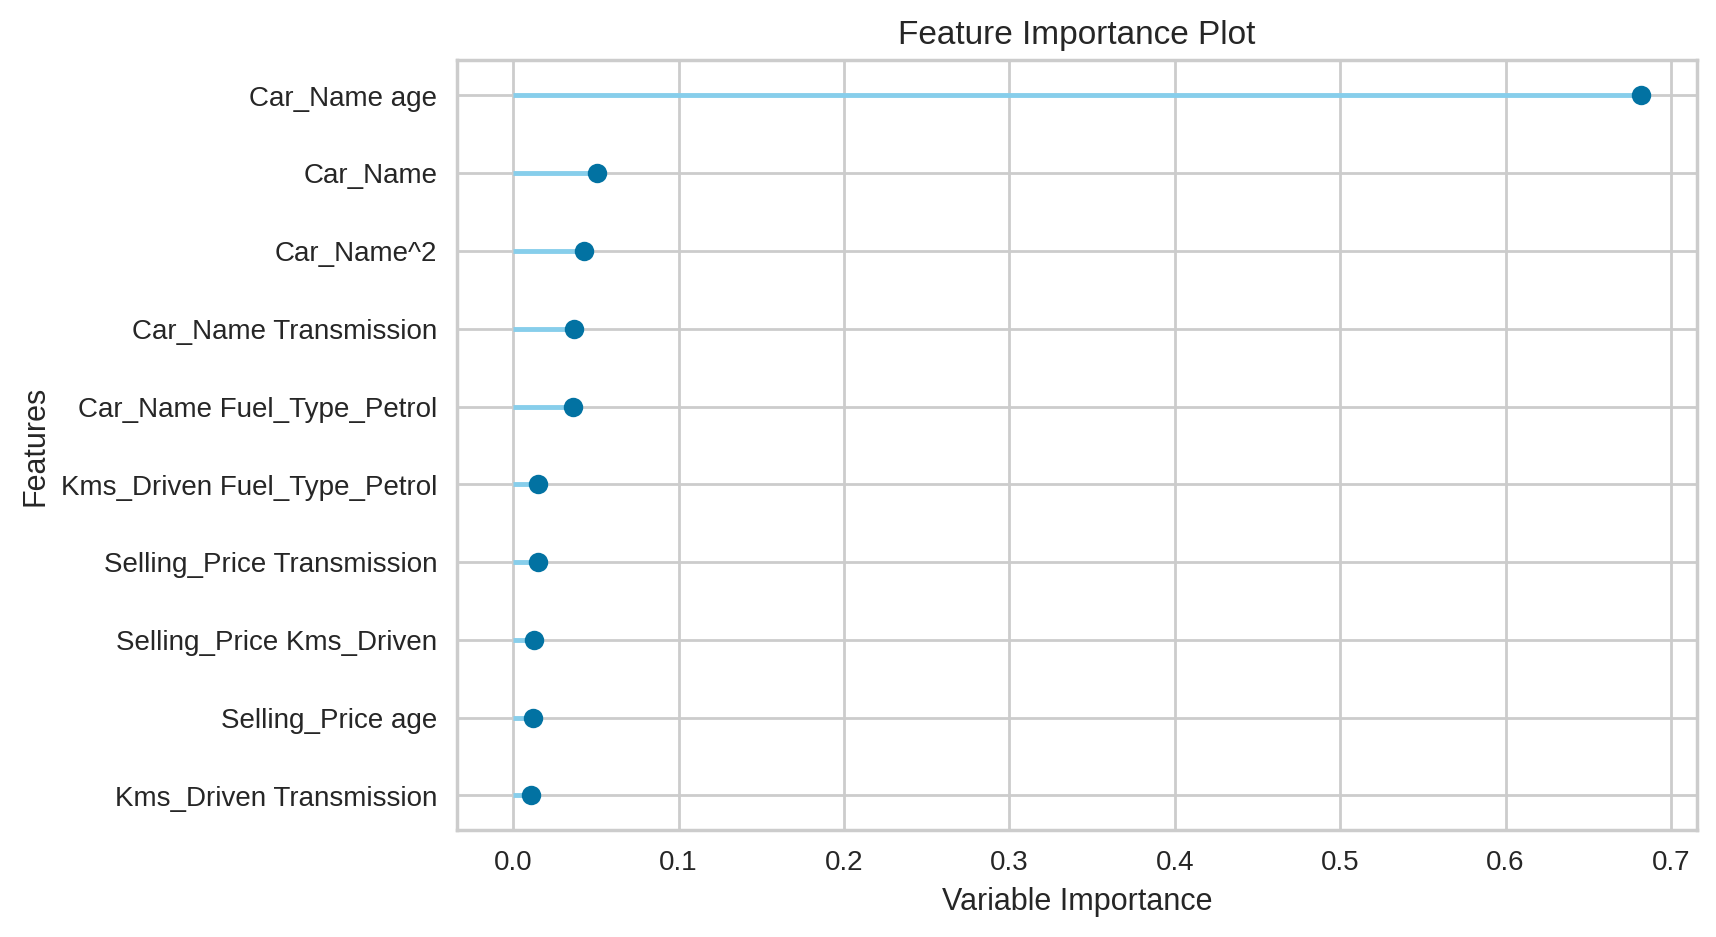

In [64]:
plot_model(best_model, plot = 'feature')

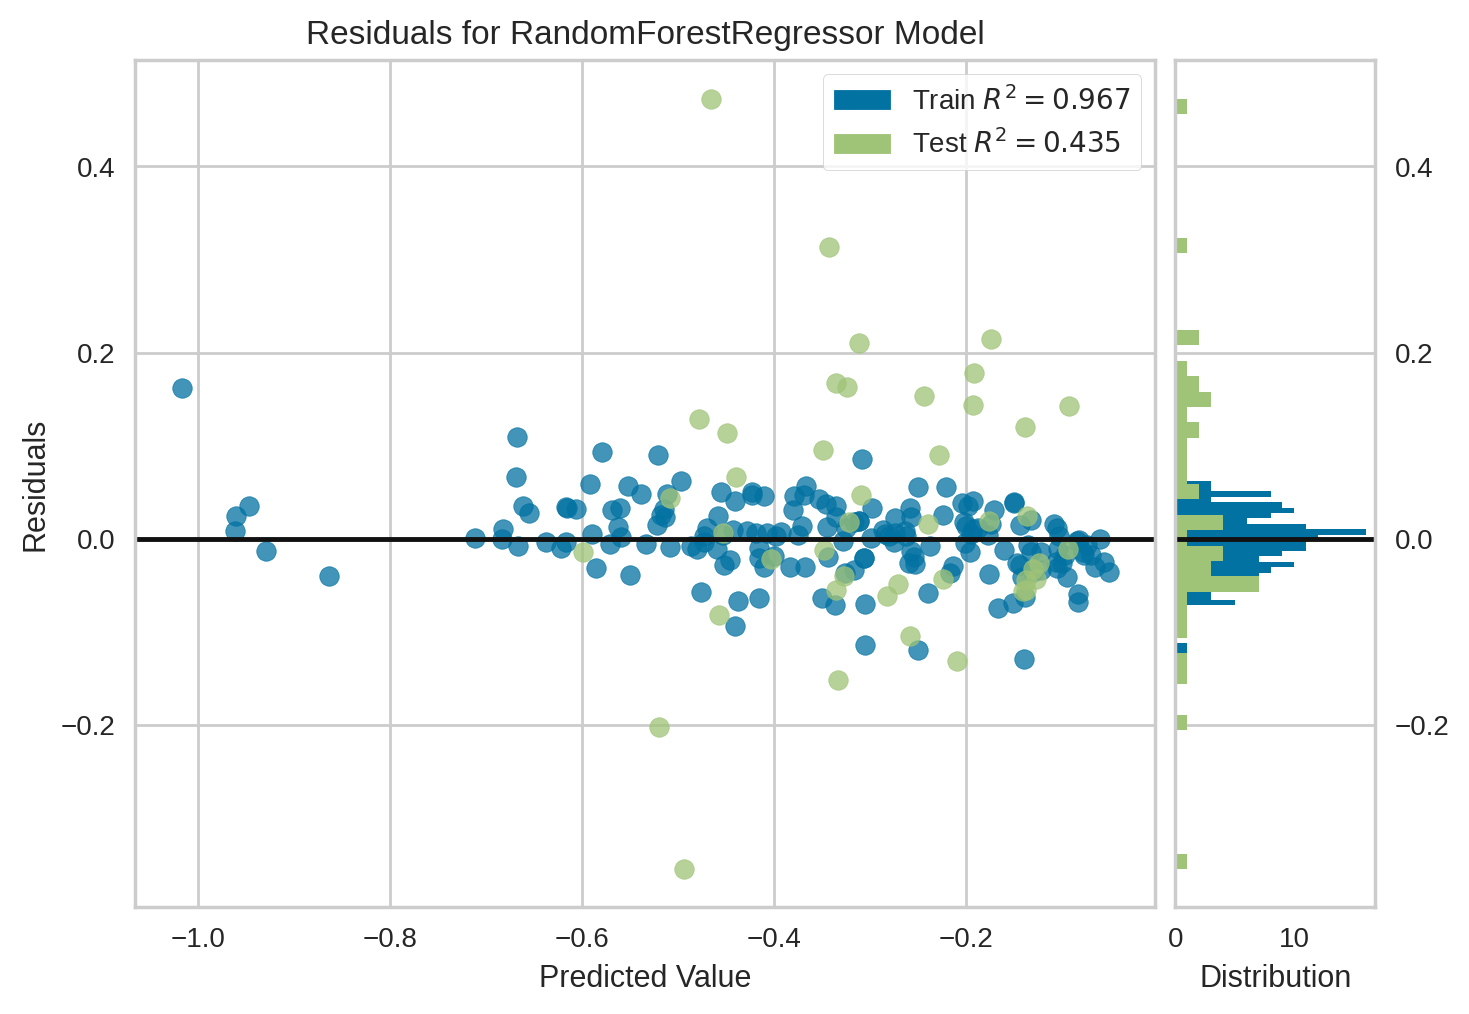

In [66]:
plot_model(best_model, plot = 'residuals')

# Model prediction

For model prediction, we can use the predict_model() function by passing in the final model. If no data is specified, the model will use the testing set that was separated during the setup() step as input for prediction. However, for this instance, I'd like to use the entire dataset as input for the model

In [52]:
# If do not specific datase, it will use testing dataset
prediction = predict_model(finalModel, data = df)
prediction

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,0.0871,0.0119,0.1092,0.7442,0.0801,0.6305


,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner,age,RV,logRV,prediction_label
0,ritz,2014,3.3500,5.5900,27000,Petrol,Dealer,Manual,0,9,0.5993,-0.5120,-0.5204
1,sx4,2013,4.7500,9.5400,43000,Diesel,Dealer,Manual,0,10,0.4979,-0.6973,-0.5753
2,ciaz,2017,7.2500,9.8500,6900,Petrol,Dealer,Manual,0,6,0.7360,-0.3065,-0.1199
4,swift,2014,4.6000,6.8700,42450,Diesel,Dealer,Manual,0,9,0.6696,-0.4011,-0.3670
5,vitara brezza,2018,9.2500,9.8300,2071,Diesel,Dealer,Manual,0,5,0.9410,-0.0608,0.0562
...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,city,2015,8.5500,13.0900,60076,Diesel,Dealer,Manual,0,8,0.6532,-0.4259,-0.3790
296,city,2016,9.5000,11.6000,33988,Diesel,Dealer,Manual,0,7,0.8190,-0.1997,-0.2572
297,brio,2015,4.0000,5.9000,60000,Petrol,Dealer,Manual,0,8,0.6780,-0.3887,-0.3589
299,city,2017,11.5000,12.5000,9000,Diesel,Dealer,Manual,0,6,0.9200,-0.0834,-0.1379


## Prediction results

To transform the results obtained from prediction back into the percentage format (since log transformation was used during training) and see the original results, you can use np.exp() to revert the values to their normal form. After that, you can calculate the yearly average from all the data and plot it as a residual curve for the final result.

In [53]:
prediction = prediction[['age', 'RV', 'prediction_label']] #Return as dataframe

# Inverse target varialbe
prediction['predictedRV'] = np.exp(prediction['prediction_label'])

# Average RV by year
averageRV = prediction.groupby(['age'], as_index = False)['RV'].mean()
averageRV['predictedRV'] = list(prediction.groupby(['age'])['predictedRV'].mean())
averageRV

,age,RV,predictedRV
0,5,0.9410,1.0578
1,6,0.8785,0.8630
2,7,0.7873,0.7829
3,8,0.7221,0.7118
4,9,0.6161,0.6281
5,10,0.5685,0.5611


## Plot results

Plot the residuals as a residual curve. The residuals are the differences between the original predictions and the actual values. The red line represents a zero residual.

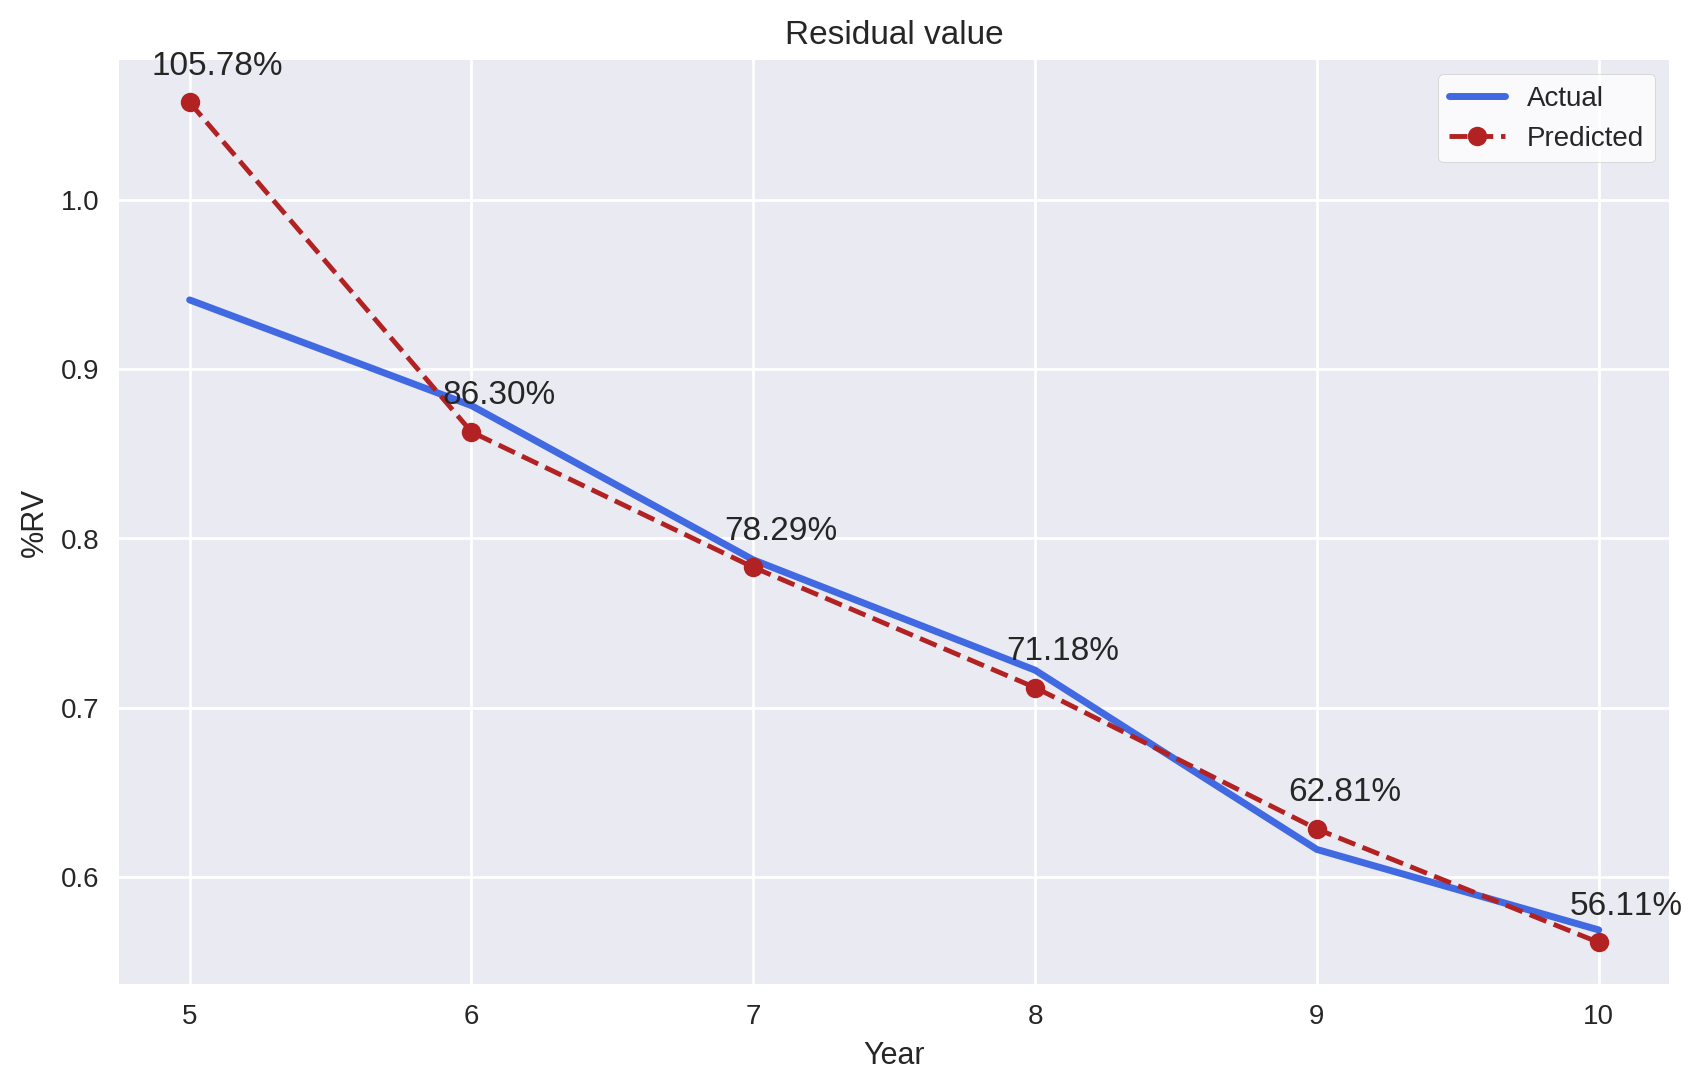

In [54]:
plt.figure(figsize = (10, 6))
with plt.style.context('seaborn'):
  plt.title('Residual value')
  plt.xlabel('Year')
  plt.ylabel('%RV')
  plt.plot(range(1, averageRV.shape[0] + 1),
           averageRV['RV'],
           c = 'royalblue',
           linewidth = 2.5,
           label = 'Actual')
  plt.plot(range(1, averageRV.shape[0] + 1),
           averageRV['predictedRV'],
           c = 'firebrick',
           linestyle = '--',
           marker = 'o',
           label = 'Predicted')
  plt.xticks(list(range(1, averageRV.shape[0] + 1)),
             averageRV['age'])

  for i, rv in enumerate(averageRV['predictedRV']):
    rvLabel = f'{rv * 100:.2f}%'
    plt.annotate(rvLabel, (i + 1, rv),
                 textcoords = 'offset points',
                 xytext = (10, 10),
                 ha = 'center')

  plt.legend(frameon = True, facecolor = 'white')
  plt.show()

# Save model

In [67]:
save_model(best_model, 'my_best_pipline')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['Kms_Driven', 'age'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=['Car_Name', 'Fuel_Type',
                                              'Transmission', 'Owner'],
                                     transformer=SimpleImputer(fill_value='constant',
                                                               strategy='constant'))),
                 ('ordinal_encoding',
                  TransformerWrappe...
                 ('rest_encoding',
                  TransformerWrapper(include=['Car_Name'],
                                     transformer=TargetEncoder(cols=['Car_Name'],
                                                               handle_missing='return_nan'))),
                 ('polynomial_features',
                  TransformerWrapper(tr

# Load the model back

In [68]:
loaded_model = load_model('my_best_pipline')
print(loaded_model)

Transformation Pipeline and Model Successfully Loaded
Pipeline(memory=FastMemory(location=/tmp/joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['Kms_Driven', 'age'],
                                    transformer=SimpleImputer())),
                ('categorical_imputer',
                 TransformerWrapper(include=['Car_Name', 'Fuel_Type',
                                             'Transmission', 'Owner'],
                                    transformer=SimpleImputer(fill_value='constant',
                                                              strategy='constant'))),
                ('ordinal_encoding',
                 Transf...
                ('rest_encoding',
                 TransformerWrapper(include=['Car_Name'],
                                    transformer=TargetEncoder(cols=['Car_Name'],
                                                              handle_missing='return_nan'))),
                ('polynomial_features',
 